# Coin Change (LeetCode 322)

## Problem

Given an integer array `coins` representing coin denominations and an integer `amount` representing a total amount of money, return the **fewest number of coins** needed to make up that amount. If that amount cannot be made up by any combination of the coins, return `-1`.

You may assume that you have an **infinite number** of each kind of coin.

### Input/Output Format
- **Input:** `coins: List[int]`, `amount: int`
- **Output:** `int` (minimum number of coins, or -1 if impossible)

### Constraints
- `1 <= coins.length <= 12`
- `1 <= coins[i] <= 2^31 - 1`
- `0 <= amount <= 10^4`

### Examples

| Input | Output | Explanation |
|-------|--------|-------------|
| `coins = [1,5,10,25], amount = 30` | `2` | 25 + 5 = 30 |
| `coins = [2], amount = 3` | `-1` | Cannot make 3 with only 2s |
| `coins = [1], amount = 0` | `0` | No coins needed for amount 0 |
| `coins = [1,3,4], amount = 6` | `2` | 3 + 3 = 6 (not 4+1+1) |

## Intuition

### The "Aha" Moment

Think of making change like climbing stairs — to reach step `amount`, you can jump from any step that's exactly one coin-value below. The minimum coins to reach `amount` is 1 + the minimum coins to reach `amount - coin`, over all coin choices.

This is the **optimal substructure** that makes dynamic programming work: the best solution for a big amount is built from the best solutions for smaller amounts.

### Why Greedy Fails

Your first instinct might be: "just always pick the largest coin that fits." This greedy approach works for US coins (1, 5, 10, 25) but **fails in general**.

**Common wrong approaches:**

1. **Greedy (always pick largest coin):** Seems reasonable because larger coins reduce the amount faster. Fails for `coins=[1,3,4], amount=6` — greedy picks 4+1+1=3 coins, but optimal is 3+3=2 coins.

2. **Brute force recursion (no memoization):** Try every combination. Correct answer but exponential time O(amount^n) — TLE on any non-trivial input.

3. **BFS without visited set:** Explore all amounts reachable by adding coins. Works but wastes time revisiting amounts already seen with fewer coins.

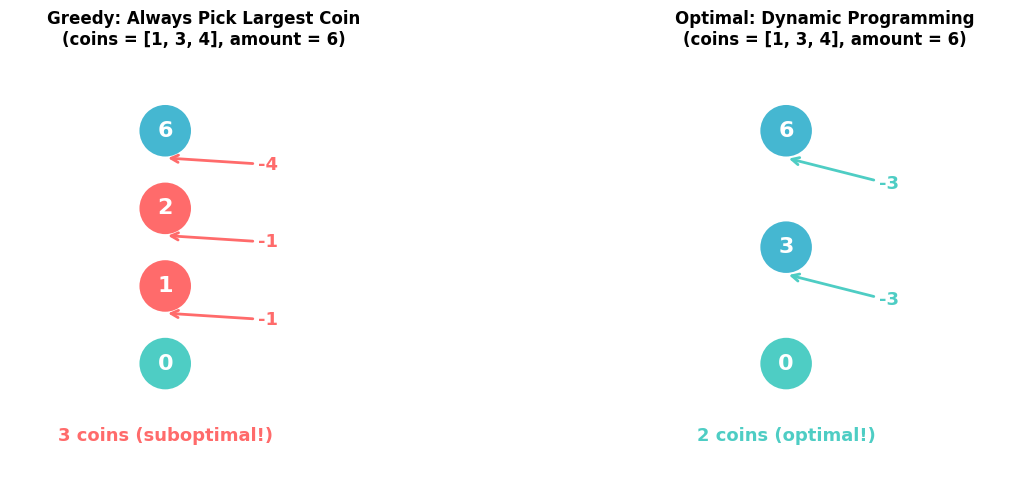

Greedy picks 4 first, then needs two 1s (3 coins).
DP finds that two 3s is better (2 coins).


In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Visualize: Why greedy fails for coins=[1,3,4], amount=6
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: Greedy path
ax = axes[0]
ax.set_title('Greedy: Always Pick Largest Coin\n(coins = [1, 3, 4], amount = 6)', fontsize=12, fontweight='bold')
greedy_path = [6, 2, 1, 0]
greedy_coins = [4, 1, 1]
y_positions = [3, 2, 1, 0]

for i, (amt, y) in enumerate(zip(greedy_path, y_positions)):
    color = '#45b7d1'
    if 0 < i < len(greedy_path) - 1:
        color = '#ff6b6b'
    if i == len(greedy_path) - 1:
        color = '#4ecdc4'
    circle = plt.Circle((2, y), 0.35, color=color, ec='white', linewidth=2)
    ax.add_patch(circle)
    ax.text(2, y, str(amt), ha='center', va='center', fontsize=16, fontweight='bold', color='white')
    if i < len(greedy_coins):
        ax.annotate(f'-{greedy_coins[i]}', xy=(2, y - 0.35), xytext=(3.2, y - 0.5),
                    fontsize=13, fontweight='bold', color='#ff6b6b',
                    arrowprops=dict(arrowstyle='->', color='#ff6b6b', lw=2))

ax.text(2, -1, '3 coins (suboptimal!)', ha='center', fontsize=13, fontweight='bold', color='#ff6b6b')
ax.set_xlim(0, 5)
ax.set_ylim(-1.5, 4)
ax.set_aspect('equal')
ax.axis('off')

# RIGHT: Optimal path
ax = axes[1]
ax.set_title('Optimal: Dynamic Programming\n(coins = [1, 3, 4], amount = 6)', fontsize=12, fontweight='bold')
optimal_path = [6, 3, 0]
optimal_coins = [3, 3]
y_positions_opt = [3, 1.5, 0]

for i, (amt, y) in enumerate(zip(optimal_path, y_positions_opt)):
    color = '#45b7d1'
    if i == len(optimal_path) - 1:
        color = '#4ecdc4'
    circle = plt.Circle((2, y), 0.35, color=color, ec='white', linewidth=2)
    ax.add_patch(circle)
    ax.text(2, y, str(amt), ha='center', va='center', fontsize=16, fontweight='bold', color='white')
    if i < len(optimal_coins):
        ax.annotate(f'-{optimal_coins[i]}', xy=(2, y - 0.35), xytext=(3.2, y - 0.75),
                    fontsize=13, fontweight='bold', color='#4ecdc4',
                    arrowprops=dict(arrowstyle='->', color='#4ecdc4', lw=2))

ax.text(2, -1, '2 coins (optimal!)', ha='center', fontsize=13, fontweight='bold', color='#4ecdc4')
ax.set_xlim(0, 5)
ax.set_ylim(-1.5, 4)
ax.set_aspect('equal')
ax.axis('off')

plt.tight_layout()
plt.show()
print('Greedy picks 4 first, then needs two 1s (3 coins).')
print('DP finds that two 3s is better (2 coins).')

## Approach

### Strategy Overview

We'll show two approaches:

1. **Top-Down DP (Memoized Recursion):** Define `minCoins(amount)` recursively — for each coin, try subtracting it and take the minimum. Cache results to avoid recomputation. Intuitive but has recursion overhead.

2. **Bottom-Up DP (Tabulation):** Build a table `dp[0..amount]` where `dp[i]` = minimum coins to make amount `i`. Fill from `dp[0] = 0` upward. Each `dp[i]` looks back at `dp[i - coin]` for each coin. No recursion stack, cache-friendly — this is the optimal approach.

### Why DP?

The problem has two key properties:
- **Optimal substructure:** The optimal solution for amount `a` uses the optimal solution for `a - coin` for some coin.
- **Overlapping subproblems:** Many different coin sequences lead to the same remaining amount — we'd recompute the same subproblems exponentially without caching.

### Data Structure Choice

A simple 1D array `dp` of size `amount + 1` is all we need. We initialize with `float('inf')` (impossible) and set `dp[0] = 0` (base case: zero coins for zero amount).

## Solution 1: Top-Down DP (Memoized Recursion)

This is the direct translation of the recursive insight: to make amount `a`, try every coin and recurse on `a - coin`.

In [2]:
from typing import List
from functools import lru_cache

class SolutionTopDown:
    def coinChange(self, coins: List[int], amount: int) -> int:
        @lru_cache(maxsize=None)
        def dp(remaining: int) -> int:
            if remaining == 0:
                return 0
            if remaining < 0:
                return float('inf')
            # Try each coin, take the choice that uses fewest coins
            best = float('inf')
            for coin in coins:
                result = dp(remaining - coin)
                if result != float('inf'):
                    best = min(best, result + 1)
            return best

        result = dp(amount)
        return result if result != float('inf') else -1

# --- Test cases ---
sol1 = SolutionTopDown()

tests = [
    ([1, 5, 10, 25], 30, 2),
    ([2], 3, -1),
    ([1], 0, 0),
    ([1, 3, 4], 6, 2),
    ([1, 2, 5], 11, 3),
    ([2, 5, 10, 1], 27, 4),
]

print('Top-Down DP Results:')
print('-' * 50)
for coins, amount, expected in tests:
    result = sol1.coinChange(coins, amount)
    status = 'PASS' if result == expected else 'FAIL'
    print(f'coins={coins}, amount={amount} -> {result} (expected {expected}) [{status}]')
    assert result == expected, f'Expected {expected}, got {result}'

print('\nAll tests passed!')

Top-Down DP Results:
--------------------------------------------------
coins=[1, 5, 10, 25], amount=30 -> 2 (expected 2) [PASS]
coins=[2], amount=3 -> -1 (expected -1) [PASS]
coins=[1], amount=0 -> 0 (expected 0) [PASS]
coins=[1, 3, 4], amount=6 -> 2 (expected 2) [PASS]
coins=[1, 2, 5], amount=11 -> 3 (expected 3) [PASS]
coins=[2, 5, 10, 1], amount=27 -> 4 (expected 4) [PASS]

All tests passed!


### Walkthrough: Top-Down DP

Tracing `coins=[1,3,4], amount=6` through the recursive calls:

In [3]:
# Trace the top-down recursion for coins=[1,3,4], amount=6
from functools import lru_cache

coins_trace = (1, 3, 4)
amount_trace = 6
call_log = []

@lru_cache(maxsize=None)
def dp_trace(remaining, depth=0):
    indent = '  ' * depth
    if remaining == 0:
        call_log.append(f'{indent}dp({remaining}) = 0  [base case]')
        return 0
    if remaining < 0:
        return float('inf')

    best = float('inf')
    best_coin = None
    for coin in coins_trace:
        result = dp_trace(remaining - coin, depth + 1)
        if result != float('inf') and result + 1 < best:
            best = result + 1
            best_coin = coin

    status = f'min coins = {best} (use coin {best_coin})' if best != float('inf') else 'impossible'
    call_log.append(f'{indent}dp({remaining}) = {best}  [{status}]')
    return best

result = dp_trace(amount_trace)
print(f'Tracing dp({amount_trace}) with coins={list(coins_trace)}:')
print('=' * 55)
for line in call_log:
    print(line)
print(f'\nFinal answer: {result} coins')
print(f'Optimal: 3 + 3 = 6 (two coins of value 3)')

Tracing dp(6) with coins=[1, 3, 4]:
            dp(0) = 0  [base case]
          dp(1) = 1  [min coins = 1 (use coin 1)]
        dp(2) = 2  [min coins = 2 (use coin 1)]
        dp(0) = 0  [base case]
      dp(3) = 1  [min coins = 1 (use coin 3)]
      dp(1) = 1  [min coins = 1 (use coin 1)]
      dp(0) = 0  [base case]
    dp(4) = 1  [min coins = 1 (use coin 4)]
    dp(2) = 2  [min coins = 2 (use coin 1)]
    dp(1) = 1  [min coins = 1 (use coin 1)]
  dp(5) = 2  [min coins = 2 (use coin 1)]
    dp(0) = 0  [base case]
  dp(3) = 1  [min coins = 1 (use coin 3)]
  dp(2) = 2  [min coins = 2 (use coin 1)]
dp(6) = 2  [min coins = 2 (use coin 3)]

Final answer: 2 coins
Optimal: 3 + 3 = 6 (two coins of value 3)


## Solution 2: Bottom-Up DP (Tabulation) — Optimal

Instead of recursion, fill a table from amount 0 upward. This eliminates recursion overhead and is the standard interview solution.

**Transition:** `dp[i] = min(dp[i - coin] + 1)` for each coin where `i - coin >= 0`.

In [4]:
from typing import List

class Solution:
    def coinChange(self, coins: List[int], amount: int) -> int:
        # dp[i] = minimum coins needed to make amount i
        dp = [float('inf')] * (amount + 1)
        dp[0] = 0  # base case: 0 coins for amount 0

        for i in range(1, amount + 1):
            for coin in coins:
                if coin <= i and dp[i - coin] != float('inf'):
                    dp[i] = min(dp[i], dp[i - coin] + 1)

        return dp[amount] if dp[amount] != float('inf') else -1

# --- Test cases ---
sol = Solution()

tests = [
    ([1, 5, 10, 25], 30, 2),
    ([2], 3, -1),
    ([1], 0, 0),
    ([1, 3, 4], 6, 2),
    ([1, 2, 5], 11, 3),
    ([2, 5, 10, 1], 27, 4),
]

print('Bottom-Up DP Results:')
print('-' * 50)
for coins, amount, expected in tests:
    result = sol.coinChange(coins, amount)
    status = 'PASS' if result == expected else 'FAIL'
    print(f'coins={coins}, amount={amount} -> {result} (expected {expected}) [{status}]')
    assert result == expected, f'Expected {expected}, got {result}'

print('\nAll tests passed!')

Bottom-Up DP Results:
--------------------------------------------------
coins=[1, 5, 10, 25], amount=30 -> 2 (expected 2) [PASS]
coins=[2], amount=3 -> -1 (expected -1) [PASS]
coins=[1], amount=0 -> 0 (expected 0) [PASS]
coins=[1, 3, 4], amount=6 -> 2 (expected 2) [PASS]
coins=[1, 2, 5], amount=11 -> 3 (expected 3) [PASS]
coins=[2, 5, 10, 1], amount=27 -> 4 (expected 4) [PASS]

All tests passed!


### Walkthrough: Bottom-Up DP

Tracing `coins=[1,3,4], amount=6` through the DP table construction:

In [5]:
# Trace the DP table fill for coins=[1,3,4], amount=6
coins = [1, 3, 4]
amount = 6

dp = [float('inf')] * (amount + 1)
dp[0] = 0

print(f'coins = {coins}, amount = {amount}')
print(f"Initial dp: {['inf' if x == float('inf') else x for x in dp]}")
print('=' * 65)

for i in range(1, amount + 1):
    old_val = dp[i]
    best_coin = None
    for coin in coins:
        if coin <= i and dp[i - coin] != float('inf'):
            new_val = dp[i - coin] + 1
            if new_val < dp[i]:
                dp[i] = new_val
                best_coin = coin

    dp_display = ['inf' if x == float('inf') else x for x in dp]
    if best_coin is not None:
        print(f'dp[{i}]: look at dp[{i}-{best_coin}] = dp[{i - best_coin}] = {dp[i - best_coin]}, '
              f'so dp[{i}] = {dp[i - best_coin]} + 1 = {dp[i]}  (use coin {best_coin})')
    else:
        print(f'dp[{i}]: no coin fits -> remains inf (impossible)')
    print(f'  dp = {dp_display}')

print(f'\nAnswer: dp[{amount}] = {dp[amount]}')
print(f'Reconstruction: 6 = 3 + 3 (two coins of value 3)')

coins = [1, 3, 4], amount = 6
Initial dp: [0, 'inf', 'inf', 'inf', 'inf', 'inf', 'inf']
dp[1]: look at dp[1-1] = dp[0] = 0, so dp[1] = 0 + 1 = 1  (use coin 1)
  dp = [0, 1, 'inf', 'inf', 'inf', 'inf', 'inf']
dp[2]: look at dp[2-1] = dp[1] = 1, so dp[2] = 1 + 1 = 2  (use coin 1)
  dp = [0, 1, 2, 'inf', 'inf', 'inf', 'inf']
dp[3]: look at dp[3-3] = dp[0] = 0, so dp[3] = 0 + 1 = 1  (use coin 3)
  dp = [0, 1, 2, 1, 'inf', 'inf', 'inf']
dp[4]: look at dp[4-4] = dp[0] = 0, so dp[4] = 0 + 1 = 1  (use coin 4)
  dp = [0, 1, 2, 1, 1, 'inf', 'inf']
dp[5]: look at dp[5-1] = dp[4] = 1, so dp[5] = 1 + 1 = 2  (use coin 1)
  dp = [0, 1, 2, 1, 1, 2, 'inf']
dp[6]: look at dp[6-3] = dp[3] = 1, so dp[6] = 1 + 1 = 2  (use coin 3)
  dp = [0, 1, 2, 1, 1, 2, 2]

Answer: dp[6] = 2
Reconstruction: 6 = 3 + 3 (two coins of value 3)


### DP Table Visualization

Visualizing how the DP table gets filled for `coins=[1,3,4], amount=6`:

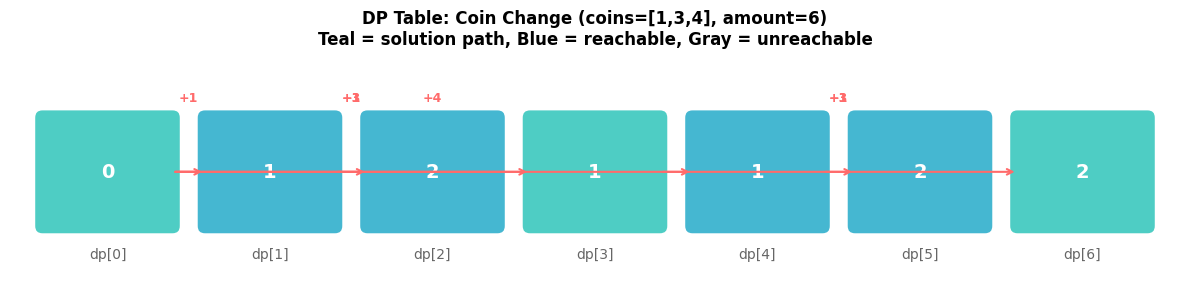

Solution path: dp[0]=0 -> dp[3]=1 (use coin 3) -> dp[6]=2 (use coin 3)


In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

coins = [1, 3, 4]
amount = 6

# Compute DP table and track which coin was used
dp = [float('inf')] * (amount + 1)
dp[0] = 0
used_coin = [None] * (amount + 1)

for i in range(1, amount + 1):
    for coin in coins:
        if coin <= i and dp[i - coin] != float('inf'):
            if dp[i - coin] + 1 < dp[i]:
                dp[i] = dp[i - coin] + 1
                used_coin[i] = coin

# Reconstruct the solution path
path = set()
a = amount
while a > 0 and used_coin[a] is not None:
    path.add(a)
    a -= used_coin[a]
path.add(0)

fig, ax = plt.subplots(figsize=(12, 4))

for i in range(amount + 1):
    val = dp[i]
    if i in path:
        color = '#4ecdc4'
        text_color = 'white'
    elif val == float('inf'):
        color = '#ddd'
        text_color = '#999'
    else:
        color = '#45b7d1'
        text_color = 'white'

    rect = patches.FancyBboxPatch((i * 1.5, 0), 1.2, 1.0,
        boxstyle='round,pad=0.08', facecolor=color, edgecolor='white', linewidth=2)
    ax.add_patch(rect)

    display_val = str(val) if val != float('inf') else 'inf'
    ax.text(i * 1.5 + 0.6, 0.5, display_val, ha='center', va='center',
            fontsize=14, fontweight='bold', color=text_color)
    ax.text(i * 1.5 + 0.6, -0.3, f'dp[{i}]', ha='center', fontsize=10, color='#666')

    if used_coin[i] is not None:
        coin = used_coin[i]
        ax.annotate('', xy=(i * 1.5, 0.5), xytext=((i - coin) * 1.5 + 1.2, 0.5),
                    arrowprops=dict(arrowstyle='->', color='#ff6b6b', lw=1.5))
        ax.text((i * 1.5 + (i - coin) * 1.5 + 1.2) / 2, 1.15, f'+{coin}',
                ha='center', fontsize=9, color='#ff6b6b', fontweight='bold')

ax.set_xlim(-0.3, (amount + 1) * 1.5)
ax.set_ylim(-0.6, 1.6)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title('DP Table: Coin Change (coins=[1,3,4], amount=6)\n'
             'Teal = solution path, Blue = reachable, Gray = unreachable',
             fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()
print('Solution path: dp[0]=0 -> dp[3]=1 (use coin 3) -> dp[6]=2 (use coin 3)')

### Animated Walkthrough

Interactive animation showing the bottom-up DP table being filled step by step for `coins=[1,3,4], amount=6`:

Rendered 11 frames.



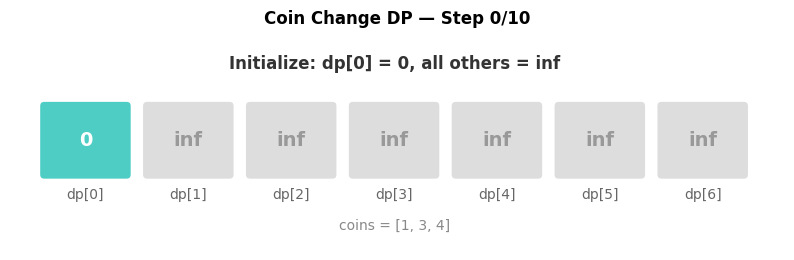

In [7]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import io
import base64
import json as _json
import random
from IPython.display import display, HTML

# --- Problem setup ---
coins = [1, 3, 4]
amount = 6

# --- Build snapshots ---
snapshots = []

dp = [float('inf')] * (amount + 1)
dp[0] = 0
used_coin = [None] * (amount + 1)

# Initial state
snapshots.append({
    'dp': dp[:],
    'used_coin': used_coin[:],
    'current_i': -1,
    'current_coin': None,
    'checking': None,
    'message': 'Initialize: dp[0] = 0, all others = inf'
})

for i in range(1, amount + 1):
    for coin in coins:
        if coin <= i:
            prev = i - coin
            checking_val = dp[prev]
            if checking_val != float('inf'):
                new_val = checking_val + 1
                if new_val < dp[i]:
                    dp[i] = new_val
                    used_coin[i] = coin
                    snapshots.append({
                        'dp': dp[:],
                        'used_coin': used_coin[:],
                        'current_i': i,
                        'current_coin': coin,
                        'checking': prev,
                        'message': f'dp[{i}] = dp[{prev}] + 1 = {new_val}  (coin={coin})'
                    })

# Final state
snapshots.append({
    'dp': dp[:],
    'used_coin': used_coin[:],
    'current_i': amount,
    'current_coin': None,
    'checking': None,
    'message': f'Done! dp[{amount}] = {dp[amount]} coins'
})

def render_frame(ax, snap, step_idx, total_steps):
    dp_vals = snap['dp']
    n = len(dp_vals)
    cur_i = snap['current_i']
    checking = snap['checking']

    for i in range(n):
        val = dp_vals[i]
        if i == cur_i:
            color = '#ff6b6b'
        elif i == checking:
            color = '#f9ca24'
        elif val != float('inf') and (cur_i < 0 or i < cur_i):
            color = '#4ecdc4'
        elif val != float('inf'):
            color = '#45b7d1'
        else:
            color = '#ddd'

        rect = patches.FancyBboxPatch((i * 1.5, 0), 1.2, 1.0,
            boxstyle='round,pad=0.08', facecolor=color, edgecolor='white', linewidth=2)
        ax.add_patch(rect)

        display_val = str(val) if val != float('inf') else 'inf'
        text_color = 'white' if color != '#ddd' else '#999'
        ax.text(i * 1.5 + 0.6, 0.5, display_val, ha='center', va='center',
                fontsize=14, fontweight='bold', color=text_color)
        ax.text(i * 1.5 + 0.6, -0.35, f'dp[{i}]', ha='center', fontsize=10, color='#666')

    if checking is not None and cur_i is not None and cur_i >= 0:
        ax.annotate('', xy=(cur_i * 1.5, 0.5),
                    xytext=(checking * 1.5 + 1.2, 0.5),
                    arrowprops=dict(arrowstyle='->', color='#ff6b6b', lw=2.5))

    ax.text(n * 1.5 / 2 - 0.15, 1.55, snap['message'],
            ha='center', fontsize=12, fontweight='bold', color='#333')

    ax.text(n * 1.5 / 2 - 0.15, -0.8, f'coins = {coins}',
            ha='center', fontsize=10, color='#888')

    ax.set_xlim(-0.5, n * 1.5 + 0.3)
    ax.set_ylim(-1.1, 2.0)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'Coin Change DP \u2014 Step {step_idx}/{total_steps - 1}',
                 fontsize=12, fontweight='bold', pad=10)

# --- Render frames ---
frames_b64 = []
for i, snap in enumerate(snapshots):
    fig, ax = plt.subplots(figsize=(10, 4))
    render_frame(ax, snap, i, len(snapshots))
    buf = io.BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=100)
    plt.close(fig)
    buf.seek(0)
    frames_b64.append(base64.b64encode(buf.read()).decode('ascii'))

assert len(frames_b64) >= 3, f'Too few frames ({len(frames_b64)}); need at least 3'
assert len(frames_b64) <= 50, f'Too many frames ({len(frames_b64)}); max is 50'
print(f'Rendered {len(frames_b64)} frames.')

# --- Player ---
uid = f'ap{random.randint(10000, 99999)}'
n_frames = len(frames_b64)

html_tpl = '''
<div id="__UID__" style="text-align:center; font-family:-apple-system,BlinkMacSystemFont,'Segoe UI',sans-serif; max-width:820px; margin:0 auto;">
  <style>
    #__UID__ .ap-frame {
      background:#fafafa; border:1px solid #e0e0e0;
      border-radius:10px; padding:12px; margin-bottom:8px;
    }
    #__UID__ .ap-frame img { max-width:100%; border-radius:6px; display:block; margin:0 auto; }
    #__UID__ .ap-controls { display:flex; justify-content:center; gap:8px; flex-wrap:wrap; }
    #__UID__ .ap-btn {
      padding:8px 16px; border:1px solid #ddd; border-radius:8px;
      background:white; font-size:14px; cursor:pointer; color:#333;
      transition:all 0.15s ease; user-select:none;
    }
    #__UID__ .ap-btn:hover:not(:disabled) { background:#f0f0f0; transform:scale(1.03); }
    #__UID__ .ap-btn:disabled { opacity:0.35; cursor:default; transform:none; }
    #__UID__ .ap-btn:active:not(:disabled) { transform:scale(0.97); }
    #__UID__ .ap-play {
      padding:8px 22px; border:none; border-radius:8px;
      background:#45b7d1; color:white; font-size:14px; font-weight:600;
      cursor:pointer; min-width:120px; transition:all 0.15s ease; user-select:none;
    }
    #__UID__ .ap-play:hover { filter:brightness(0.9); transform:scale(1.03); }
    #__UID__ .ap-play:active { transform:scale(0.97); }
    #__UID__ .ap-slider-row input[type=range] {
      width:80%; accent-color:#45b7d1; cursor:pointer; height:6px;
    }
    #__UID__ .ap-speed-row {
      display:flex; justify-content:center; align-items:center;
      gap:6px; margin-top:10px; flex-wrap:wrap;
    }
    #__UID__ .ap-speed-label {
      font-size:13px; color:#888; font-weight:500; margin-right:2px;
    }
    #__UID__ .ap-speed {
      padding:4px 12px; border:1px solid #ddd; border-radius:6px;
      background:white; font-size:13px; cursor:pointer; color:#555;
      transition:all 0.15s ease; user-select:none;
    }
    #__UID__ .ap-speed:hover { background:#f0f0f0; }
    #__UID__ .ap-speed.active {
      background:#45b7d1; color:white; border-color:#45b7d1; font-weight:600;
    }
  </style>
  <div class="ap-frame">
    <img id="__UID__-img" src="data:image/png;base64,__FIRST_FRAME__">
  </div>
  <div class="ap-slider-row" style="margin:10px 0 4px;">
    <input type="range" id="__UID__-slider" min="0" max="__MAX__" value="0">
  </div>
  <div id="__UID__-label" style="margin:2px 0 14px; font-size:15px; color:#555; font-weight:500;">
    Step 0 / __MAX__
  </div>
  <div class="ap-controls">
    <button class="ap-btn" id="__UID__-back" title="Go back one step">&#9664; Back</button>
    <button class="ap-play" id="__UID__-play" title="Play / Pause">&#9654;  Play</button>
    <button class="ap-btn" id="__UID__-fwd" title="Go forward one step">Next &#9654;</button>
    <button class="ap-btn" id="__UID__-replay" title="Start over from the beginning">&#8635; Replay</button>
  </div>
  <div class="ap-speed-row">
    <span class="ap-speed-label">Speed:</span>
    <button class="ap-speed" data-ms="2000">0.5x</button>
    <button class="ap-speed active" data-ms="1000">1x</button>
    <button class="ap-speed" data-ms="500">2x</button>
    <button class="ap-speed" data-ms="333">3x</button>
    <button class="ap-speed" data-ms="200">5x</button>
  </div>
</div>
'''

js_tpl = '''
<script>
(function() {
  var frames = __FRAMES__;
  var cur = 0, playing = false, tmr = null, N = frames.length, MS = 1000;
  var el = function(s) { return document.getElementById('__UID__-' + s); };
  var img = el('img'), sld = el('slider'), lbl = el('label');
  var btnPlay = el('play'), btnBack = el('back'), btnFwd = el('fwd');
  var container = document.getElementById('__UID__');

  function show(i) {
    cur = Math.max(0, Math.min(N - 1, i));
    img.src = 'data:image/png;base64,' + frames[cur];
    sld.value = cur;
    lbl.textContent = 'Step ' + cur + ' / ' + (N - 1);
    btnBack.disabled = (cur === 0);
    btnFwd.disabled = (cur === N - 1);
  }

  function tick() {
    if (!playing || cur >= N - 1) { stopPlay(); return; }
    show(cur + 1);
    tmr = setTimeout(tick, MS);
  }

  function startPlay() {
    if (cur >= N - 1) show(0);
    playing = true;
    btnPlay.innerHTML = '&#9646;&#9646;  Pause';
    btnPlay.style.background = '#e74c3c';
    tmr = setTimeout(tick, MS);
  }

  function stopPlay() {
    playing = false;
    btnPlay.innerHTML = '&#9654;  Play';
    btnPlay.style.background = '#45b7d1';
    if (tmr) { clearTimeout(tmr); tmr = null; }
  }

  btnPlay.onclick = function() { playing ? stopPlay() : startPlay(); };
  btnBack.onclick = function() { stopPlay(); show(cur - 1); };
  btnFwd.onclick = function() { stopPlay(); show(cur + 1); };
  el('replay').onclick = function() { show(0); startPlay(); };
  sld.oninput = function() { stopPlay(); show(parseInt(this.value)); };

  var speedBtns = container.querySelectorAll('.ap-speed');
  for (var i = 0; i < speedBtns.length; i++) {
    speedBtns[i].onclick = (function(btn) {
      return function() {
        MS = parseInt(btn.getAttribute('data-ms'));
        for (var j = 0; j < speedBtns.length; j++)
          speedBtns[j].classList.remove('active');
        btn.classList.add('active');
        if (playing) {
          if (tmr) { clearTimeout(tmr); tmr = null; }
          tmr = setTimeout(tick, MS);
        }
      };
    })(speedBtns[i]);
  }

  show(0);
})();
</script>
'''

player_html = (html_tpl
    .replace('__UID__', uid)
    .replace('__FIRST_FRAME__', frames_b64[0])
    .replace('__MAX__', str(n_frames - 1)))

player_js = (js_tpl
    .replace('__FRAMES__', _json.dumps(frames_b64))
    .replace('__UID__', uid))

display(HTML(player_html + player_js))

## Benchmark

Comparing top-down vs bottom-up DP on increasing input sizes to see the practical performance difference:

  Amount | Dict-memo (ms) |  Array-DP (ms) |  Speedup
----------------------------------------------------------
     100 |         0.210 |         0.180 |     1.2x
     500 |         0.695 |         0.478 |     1.5x
    1000 |         0.965 |         0.698 |     1.4x
    5000 |         4.981 |        16.132 |     0.3x
   10000 |         9.608 |         7.554 |     1.3x


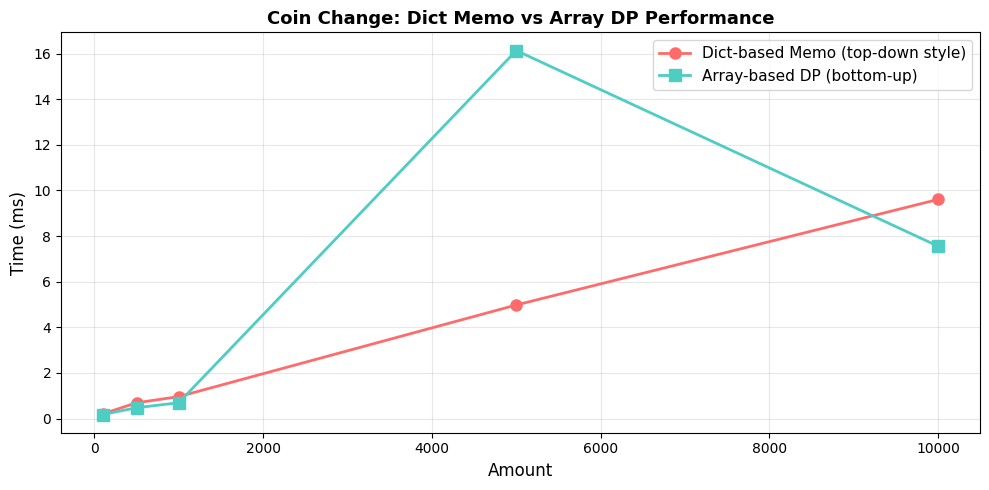


Both are O(amount * len(coins)). The array version is faster due to:
  - Cache locality: contiguous array vs hash table lookups
  - No hashing overhead: direct index access vs dict key hashing
  - The gap widens with larger amounts.


In [8]:
import time
import matplotlib.pyplot as plt

def coin_change_topdown_iter(coins, amount):
    """Top-down DP using iterative deepening to avoid recursion limits."""
    memo = {0: 0}
    # Iteratively fill memo bottom-up to simulate top-down without deep recursion
    for rem in range(1, amount + 1):
        best = float('inf')
        for coin in coins:
            prev = rem - coin
            if prev >= 0 and prev in memo and memo[prev] != float('inf'):
                best = min(best, memo[prev] + 1)
        memo[rem] = best
    result = memo.get(amount, float('inf'))
    return result if result != float('inf') else -1

def coin_change_bottomup(coins, amount):
    """Bottom-up DP with array (cache-friendly)."""
    dp = [float('inf')] * (amount + 1)
    dp[0] = 0
    for i in range(1, amount + 1):
        for coin in coins:
            if coin <= i and dp[i - coin] != float('inf'):
                dp[i] = min(dp[i], dp[i - coin] + 1)
    return dp[amount] if dp[amount] != float('inf') else -1

coins = [1, 5, 10, 25]
sizes = [100, 500, 1000, 5000, 10000]

topdown_times = []
bottomup_times = []

print(f"{'Amount':>8} | {'Dict-memo (ms)':>14} | {'Array-DP (ms)':>14} | {'Speedup':>8}")
print('-' * 58)

for amt in sizes:
    # Dict-based memo (simulates top-down overhead)
    start = time.perf_counter()
    for _ in range(5):
        coin_change_topdown_iter(coins, amt)
    td_time = (time.perf_counter() - start) / 5 * 1000
    topdown_times.append(td_time)

    # Array-based bottom-up
    start = time.perf_counter()
    for _ in range(5):
        coin_change_bottomup(coins, amt)
    bu_time = (time.perf_counter() - start) / 5 * 1000
    bottomup_times.append(bu_time)

    speedup = td_time / bu_time if bu_time > 0 else float('inf')
    print(f'{amt:>8} | {td_time:>13.3f} | {bu_time:>13.3f} | {speedup:>7.1f}x')

# Plot
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(sizes, topdown_times, 'o-', color='#ff6b6b', linewidth=2, markersize=8, label='Dict-based Memo (top-down style)')
ax.plot(sizes, bottomup_times, 's-', color='#4ecdc4', linewidth=2, markersize=8, label='Array-based DP (bottom-up)')
ax.set_xlabel('Amount', fontsize=12)
ax.set_ylabel('Time (ms)', fontsize=12)
ax.set_title('Coin Change: Dict Memo vs Array DP Performance', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print('\nBoth are O(amount * len(coins)). The array version is faster due to:')
print('  - Cache locality: contiguous array vs hash table lookups')
print('  - No hashing overhead: direct index access vs dict key hashing')
print('  - The gap widens with larger amounts.')

## Complexity Analysis

### Time Complexity: O(amount x len(coins))

- We fill `amount` entries in the DP table
- For each entry, we check all `len(coins)` denominations
- Total work: `amount x len(coins)` operations
- For `amount = 10,000` and `12` coins, that's ~120,000 operations — very fast

### Space Complexity: O(amount)

- We store a 1D array of size `amount + 1`
- The top-down version additionally uses O(amount) stack space for recursion
- Bottom-up uses only the DP array — no recursion stack

### Why This Is Optimal

- We must consider every amount from 1 to `amount` (can't skip any)
- For each amount, we must try all coins (any could yield the minimum)
- So O(amount x coins) is a lower bound for this approach
- No known algorithm does better in the general case

## Edge Cases & Follow-ups

### Edge Cases to Watch For

1. **amount = 0:** Return 0 (no coins needed)
2. **Single coin that doesn't divide amount:** e.g., `coins=[2], amount=3` -> return -1
3. **Large coin values:** Don't iterate up to coin value if it exceeds amount
4. **Single coin = 1:** Always possible, answer is simply `amount`
5. **All coins larger than amount:** Return -1 (except if amount = 0)

In [9]:
# Edge case tests
# (reusing Solution class from earlier cell)

edge_cases = [
    # (coins, amount, expected, description)
    ([1, 5, 10, 25], 0, 0, 'amount = 0'),
    ([2], 3, -1, 'impossible: single coin does not divide'),
    ([1], 100, 100, 'single coin = 1: answer is amount'),
    ([5, 10, 25], 3, -1, 'all coins larger than amount'),
    ([1, 2147483647], 2, 2, 'very large coin denomination'),
    ([3, 7], 1, -1, 'small amount, no coin fits'),
    ([1, 3, 4], 6, 2, 'greedy would fail'),
    ([2], 1, -1, 'odd amount with only even coins'),
    ([186, 419, 83, 408], 6249, 20, 'non-standard denominations'),
]

print('Edge Case Tests:')
print('-' * 65)
for coins, amount, expected, desc in edge_cases:
    result = sol.coinChange(coins, amount)
    status = 'PASS' if result == expected else 'FAIL'
    print(f'[{status}] {desc}')
    print(f'      coins={coins}, amount={amount} -> {result} (expected {expected})')
    assert result == expected, f'Expected {expected}, got {result}'

print('\nAll edge cases passed!')

Edge Case Tests:
-----------------------------------------------------------------
[PASS] amount = 0
      coins=[1, 5, 10, 25], amount=0 -> 0 (expected 0)
[PASS] impossible: single coin does not divide
      coins=[2], amount=3 -> -1 (expected -1)
[PASS] single coin = 1: answer is amount
      coins=[1], amount=100 -> 100 (expected 100)
[PASS] all coins larger than amount
      coins=[5, 10, 25], amount=3 -> -1 (expected -1)
[PASS] very large coin denomination
      coins=[1, 2147483647], amount=2 -> 2 (expected 2)
[PASS] small amount, no coin fits
      coins=[3, 7], amount=1 -> -1 (expected -1)
[PASS] greedy would fail
      coins=[1, 3, 4], amount=6 -> 2 (expected 2)
[PASS] odd amount with only even coins
      coins=[2], amount=1 -> -1 (expected -1)
[PASS] non-standard denominations
      coins=[186, 419, 83, 408], amount=6249 -> 20 (expected 20)

All edge cases passed!


### Follow-ups

- **What if you also need to return which coins to use?** Track the coin used at each DP step and reconstruct the path backward.
- **What if each coin can only be used once?** That's a different problem — the 0/1 Knapsack variant. You'd iterate coins in the outer loop and amounts in reverse.
- **What if you need to count the number of ways (not minimum coins)?** Change `min` to `sum` — that's LeetCode 518 (Coin Change II).

## Pattern & Generalization

### Pattern: Unbounded Knapsack / 1D DP with Choices

Coin Change is the canonical example of **unbounded knapsack** — you have unlimited items (coins) and want to optimize a quantity (minimize count) subject to a capacity constraint (amount).

### When to Recognize This Pattern

Apply this pattern when you see:
- **"Minimum/maximum number of X to reach Y"** with unlimited supply
- **"Can you reach target T by combining items?"** (feasibility variant)
- **"How many ways to reach target T?"** (counting variant)

### When This Pattern Doesn't Work

1. **Items can only be used once** -> Use 0/1 Knapsack (iterate amounts in reverse)
2. **Order of items matters** -> This is a permutation problem, not a combination problem. DP recurrence changes.
3. **Multiple constraints** (e.g., weight AND volume) -> Need 2D DP

### Real-World Applications

- **Network routing:** Minimum hops to reach a destination with fixed link costs
- **Resource allocation:** Minimum number of containers to fill a capacity
- **Currency systems:** Verifying that a denomination set allows efficient change-making
- **Cutting stock problem:** Minimize waste when cutting material into required lengths

## Related Problems

| # | Problem | Connection |
|---|---------|------------|
| 518 | [Coin Change II](https://leetcode.com/problems/coin-change-ii/) | Same setup but count **number of ways** instead of minimum coins |
| 279 | [Perfect Squares](https://leetcode.com/problems/perfect-squares/) | Same DP pattern — "coins" are perfect squares 1, 4, 9, 16, ... |
| 377 | [Combination Sum IV](https://leetcode.com/problems/combination-sum-iv/) | Order matters (permutations), so outer loop is over amounts |
| 1049 | [Last Stone Weight II](https://leetcode.com/problems/last-stone-weight-ii/) | 0/1 Knapsack variant — partition stones into two groups |
| 983 | [Minimum Cost For Tickets](https://leetcode.com/problems/minimum-cost-for-tickets/) | 1D DP with choices — "coins" are ticket durations (1, 7, 30 days) |

## Practice Exercises

Try these variations to deepen your understanding:

In [10]:
# Exercise 1: Reconstruct the actual coins used (not just the count)
# Given coins and amount, return the LIST of coins used in the optimal solution.

def coin_change_with_path(coins, amount):
    dp = [float('inf')] * (amount + 1)
    dp[0] = 0
    parent = [-1] * (amount + 1)  # Track which coin was used

    for i in range(1, amount + 1):
        for coin in coins:
            if coin <= i and dp[i - coin] + 1 < dp[i]:
                dp[i] = dp[i - coin] + 1
                parent[i] = coin

    if dp[amount] == float('inf'):
        return -1, []

    # Reconstruct path
    path = []
    a = amount
    while a > 0:
        path.append(parent[a])
        a -= parent[a]

    return dp[amount], path

# Test it
count, coins_used = coin_change_with_path([1, 3, 4], 6)
print(f'Exercise 1: Coin Change with Path Reconstruction')
print(f'  coins=[1,3,4], amount=6 -> {count} coins: {coins_used}')
assert count == 2 and sorted(coins_used) == [3, 3]

count, coins_used = coin_change_with_path([1, 5, 10, 25], 30)
print(f'  coins=[1,5,10,25], amount=30 -> {count} coins: {coins_used}')
assert count == 2
print()

# Exercise 2: Count the number of ways to make change (Coin Change II)
# Hint: change min to sum, and be careful about the loop order!
print('Exercise 2: Count Ways to Make Change')
print('  Try implementing this yourself! Starter code below:')
print()

def count_ways(coins, amount):
    """Return the number of distinct combinations of coins that sum to amount."""
    dp = [0] * (amount + 1)
    dp[0] = 1  # one way to make 0: use no coins
    for coin in coins:  # outer loop over coins prevents duplicate counting
        for i in range(coin, amount + 1):
            dp[i] += dp[i - coin]
    return dp[amount]

# Test
result = count_ways([1, 2, 5], 5)
print(f'  count_ways([1,2,5], 5) = {result}')
assert result == 4  # {5}, {2+2+1}, {2+1+1+1}, {1+1+1+1+1}
print(f'  4 ways: [5], [2+2+1], [2+1+1+1], [1+1+1+1+1]')
print()

# Exercise 3: What if coins can only be used ONCE? (0/1 variant)
print('Exercise 3: Coin Change with Limited Supply (each coin used at most once)')
print('  Hint: iterate amounts in REVERSE to prevent reuse!')
print()

def coin_change_limited(coins, amount):
    """Each coin can be used at most once. Return min coins or -1."""
    dp = [float('inf')] * (amount + 1)
    dp[0] = 0
    for coin in coins:  # outer loop: consider each coin once
        for i in range(amount, coin - 1, -1):  # reverse to prevent reuse
            if dp[i - coin] != float('inf'):
                dp[i] = min(dp[i], dp[i - coin] + 1)
    return dp[amount] if dp[amount] != float('inf') else -1

result = coin_change_limited([1, 3, 4, 5], 7)
print(f'  coin_change_limited([1,3,4,5], 7) = {result}')
assert result == 2  # 3+4=7
print(f'  2 coins: 3 + 4 = 7')

result = coin_change_limited([2, 4], 5)
print(f'  coin_change_limited([2,4], 5) = {result}')
assert result == -1
print(f'  Impossible with only one of each coin')

Exercise 1: Coin Change with Path Reconstruction
  coins=[1,3,4], amount=6 -> 2 coins: [3, 3]
  coins=[1,5,10,25], amount=30 -> 2 coins: [5, 25]

Exercise 2: Count Ways to Make Change
  Try implementing this yourself! Starter code below:

  count_ways([1,2,5], 5) = 4
  4 ways: [5], [2+2+1], [2+1+1+1], [1+1+1+1+1]

Exercise 3: Coin Change with Limited Supply (each coin used at most once)
  Hint: iterate amounts in REVERSE to prevent reuse!

  coin_change_limited([1,3,4,5], 7) = 2
  2 coins: 3 + 4 = 7
  coin_change_limited([2,4], 5) = -1
  Impossible with only one of each coin
